# Text Analizer using Python and RegEx

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', -1)

# Text mining
## Data preparation
In this work I'm going to analyse the project names of several KickStarter projects.
You can find the data set in Kaggle: https://www.kaggle.com/kemical/kickstarter-projects/data

In [3]:
#read data
df = pd.read_csv('data_textmining.csv', index_col=0, encoding='utf-8-sig')

In [4]:
# create a copy and drop no related columns
df = df.drop([ 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'date_diff', 'rtdate', 'rate', 'goal_usd', 'pledged_usd'], axis=1)
dfname = df.copy()

In [5]:
dfname.head()

,name,category,main_category,country,successful
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GB,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,US,0
2,Where is Hank?,Narrative Film,Film & Video,US,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0
4,Community Film Project: The Art of Neighborhood Filmmaking,Film & Video,Film & Video,US,0


In [6]:
# make sure all names are string
dfname['name'] = dfname.name.astype(str)

# there are 23105  projects with (canceled) in the name
pattern = '\(canceled\)'
dfname['name'] = dfname.name.str.replace(pattern, '', n=1, case=False)

# there are 1060  projects with (suspended) in the name
pattern = '\(suspended\)'
dfname['name'] = dfname.name.str.replace(pattern, '', n=1, case=False)

#remove rare characters 
pattern = '[^A-Za-z0-9!? ]'
dfname['name'] = dfname.name.str.replace(pattern, '')

pattern = '\(\)'
dfname['name'] = dfname.name.str.replace(pattern, '')

#remove excess whitespace
for i in range(8):
    pattern = '  '
    dfname['name'] = dfname.name.str.replace(pattern, ' ')

In [7]:
# create new feature: name length
dfname['name_len'] = dfname.name.str.len()

# convert all to lowercase before split
dfname['name_low'] = dfname.name.str.lower()

# get rid of ? ! before split
pattern = '[!?]'
dfname['name_low'] = dfname.name_low.str.replace(pattern, '')

# drop empty names
dfname = dfname.drop(dfname[dfname.name_len == 0].index, axis=0)
dfname = dfname.drop(dfname[dfname.name == ' '].index, axis=0) 

# split each name by whitespace creating a list with words
dfname['name_words']  = dfname.name_low.str.strip().str.split('[\s]')

# create new feature: number of words in each name
dfname['number_words']  =  dfname.name_words.str.len()

In [8]:
dfname.name_words.isnull().sum()

0

In [9]:
dfname.head()

,name,category,main_category,country,successful,name_len,name_low,name_words,number_words
0,The Songs of Adelaide Abullah,Poetry,Publishing,GB,0,29,the songs of adelaide abullah,"[the, songs, of, adelaide, abullah]",5
1,Greeting From Earth ZGAC Arts Capsule For ET,Narrative Film,Film & Video,US,0,44,greeting from earth zgac arts capsule for et,"[greeting, from, earth, zgac, arts, capsule, for, et]",8
2,Where is Hank?,Narrative Film,Film & Video,US,0,14,where is hank,"[where, is, hank]",3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0,49,toshicapital rekordz needs help to complete album,"[toshicapital, rekordz, needs, help, to, complete, album]",7
4,Community Film Project The Art of Neighborhood Filmmaking,Film & Video,Film & Video,US,0,57,community film project the art of neighborhood filmmaking,"[community, film, project, the, art, of, neighborhood, filmmaking]",8


## Word count
** I want to know how many times each word is used in successful or failed projects.**

In [10]:
# create a safe copy
table2 = dfname.copy()

In [11]:
rows= list()
for row in table2[['successful', 'name_words']].iterrows():
    r = row[1]
    for word in r.name_words:
        rows.append((r.successful, word))
        
words = pd.DataFrame(rows, columns=['successful', 'word'])
words.head()

,successful,word
0,0,the
1,0,songs
2,0,of
3,0,adelaide
4,0,abullah


In [12]:
# drop empty words
words = words.drop(words[words.word == ''].index, axis=0)

# pivot table
count_words = words.pivot_table(index = 'word', columns='successful',aggfunc=np.size)

count_words = count_words.sort_values(1, ascending=False)

# save to csv for further analysis
#count_words.to_csv('count_words.csv', encoding='utf-8-sig')

# create new features
n_successful = len(dfname[dfname.successful == 1])

n_failed = len(dfname[dfname.successful == 0])

count_words['prop_successful'] = count_words[1] / n_successful

count_words['prop_failed'] = count_words[0] / n_failed

count_words['diff'] = count_words['prop_successful'] - count_words['prop_failed']

# which words are more used in successful projects than in failed projects?
sorted_bydiff = count_words.sort_values(by='diff', ascending=False)
sorted_bydiff[:10]
#the is a connecting word, gives more information about a project

successful,0,1,prop_successful,prop_failed,diff
word,,,,,
the,127362.0,82720.0,0.603611,0.527143,0.076467
album,11628.0,16426.0,0.119861,0.048128,0.071734
a,59404.0,42984.0,0.313656,0.245869,0.067786
new,13696.0,14036.0,0.102421,0.056687,0.045734
film,11618.0,11644.0,0.084967,0.048086,0.036880
debut,3840.0,6138.0,0.044789,0.015894,0.028896
by,10274.0,9764.0,0.071248,0.042523,0.028725
short,4620.0,6236.0,0.045504,0.019122,0.026382
ep,4056.0,5692.0,0.041535,0.016788,0.024747


In [13]:
# drop some of the most common words in English (source: https://simple.wikipedia.org/wiki/Most_common_words_in_English)
most10 = ['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'I', 'by', 'at', 'an', 'from', '1', '2', 'about', 
          'is', 'on']
most100diff = sorted_bydiff[:111]

for row in most100diff.iterrows():
    if row[0] in most10:
        most100diff = most100diff.drop(row[0])

most100diff.head()

successful,0,1,prop_successful,prop_failed,diff
word,,,,,
album,11628.0,16426.0,0.119861,0.048128,0.071734
new,13696.0,14036.0,0.102421,0.056687,0.045734
film,11618.0,11644.0,0.084967,0.048086,0.036880
debut,3840.0,6138.0,0.044789,0.015894,0.028896
short,4620.0,6236.0,0.045504,0.019122,0.026382


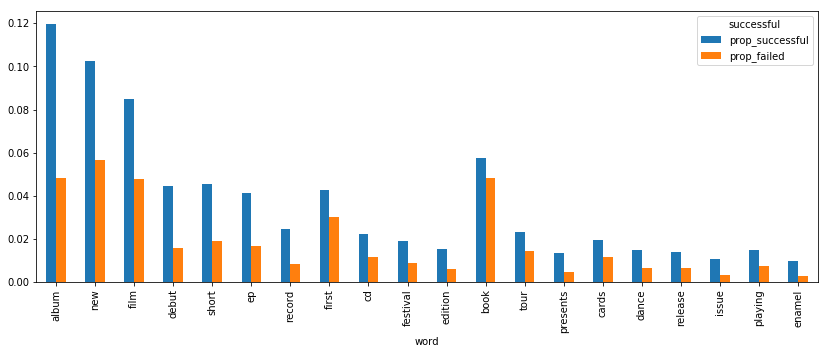

In [14]:
plt.rc('figure', figsize=(14, 5))
most20diff = most100diff[['prop_successful', 'prop_failed']][:20]
most20diff.plot.bar();

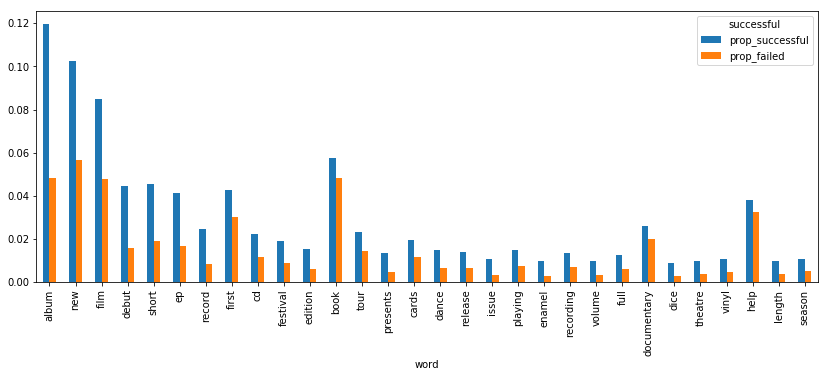

In [15]:
most30diff = most100diff[['prop_successful', 'prop_failed']][:30]
most30diff.plot.bar();

We can see that projects with names containing words related to music, books, games and arts are more successful.

In [16]:
#http://www.enchantedlearning.com/wordlist/?

In [17]:
most30diff.index

Index(['album', 'new', 'film', 'debut', 'short', 'ep', 'record', 'first', 'cd',
       'festival', 'edition', 'book', 'tour', 'presents', 'cards', 'dance',
       'release', 'issue', 'playing', 'enamel', 'recording', 'volume', 'full',
       'documentary', 'dice', 'theatre', 'vinyl', 'help', 'length', 'season'],
      dtype='object', name='word')

# Analysis

In [18]:
dfkey = dfname.copy()

In [19]:
dfkey['contain_kw'] = np.zeros(len(dfkey))

In [20]:
# define keywords to analize
keywords =  ['album', 'new', 'film', 'debut', 'short', 'ep', 'record', 'first', 'cd',
       'festival', 'edition', 'book', 'tour', 'presents', 'cards', 'dance',
       'release', 'issue', 'playing', 'enamel', 'recording', 'volume', 'full',
       'documentary', 'dice', 'theatre', 'vinyl', 'help', 'length', 'season']

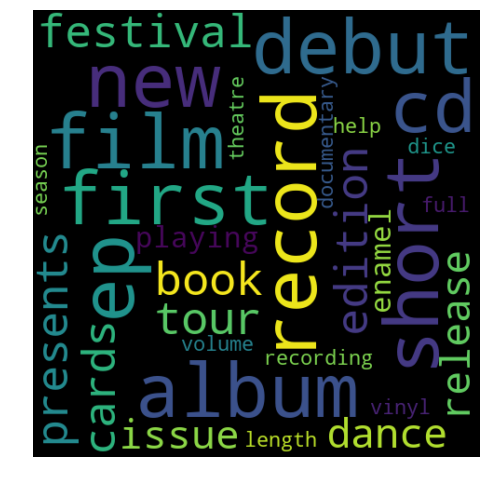

In [21]:
# Libraries
from wordcloud import WordCloud
# Create the wordcloud object
key = ' '.join(keywords)
wordcloud = WordCloud(width=480, height=480, max_font_size=80, min_font_size=10).generate(key)
 
# Display the generated image:
plt.rc('figure', figsize=(8, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

In [22]:
keywords =  ['album', 'new', 'film', 'debut', 'short', 'ep', 'record', 'first', 'cd',
       'festival', 'edition', 'book', 'tour', 'presents', 'cards', 'dance',
       'release', 'issue', 'playing', 'enamel', 'recording', 'volume', 'full',
       'documentary', 'dice', 'theatre', 'vinyl', 'help', 'length', 'season']
for word in keywords:
    dfkey['contain_kw'] = np.where(dfkey.name_low.str.contains(word),1 ,dfkey['contain_kw'])

dfkey.contain_kw = dfkey.contain_kw.astype(int)

In [23]:
dfkey[dfkey.contain_kw == 1] 

,name,category,main_category,country,successful,name_len,name_low,name_words,number_words,contain_kw
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0,49,toshicapital rekordz needs help to complete album,"[toshicapital, rekordz, needs, help, to, complete, album]",7,1
4,Community Film Project The Art of Neighborhood Filmmaking,Film & Video,Film & Video,US,0,57,community film project the art of neighborhood filmmaking,"[community, film, project, the, art, of, neighborhood, filmmaking]",8,1
9,STUDIO IN THE SKY A Documentary Feature Film,Documentary,Film & Video,US,0,45,studio in the sky a documentary feature film,"[studio, in, the, sky, a, documentary, feature, film]",8,1
11,Lisa Lim New CD!,Indie Rock,Music,US,1,16,lisa lim new cd,"[lisa, lim, new, cd]",4,1
18,Mike Coreys Darkness Light Album,Music,Music,US,1,32,mike coreys darkness light album,"[mike, coreys, darkness, light, album]",5,1
20,CMUK Shoes Take on Life Feet First,Fashion,Fashion,US,1,34,cmuk shoes take on life feet first,"[cmuk, shoes, take, on, life, feet, first]",7,1
24,The Book Zoo A MiniComic,Comics,Comics,US,1,24,the book zoo a minicomic,"[the, book, zoo, a, minicomic]",5,1
25,Matt Cavenaugh Jenny Powers make their 1st album!,Music,Music,US,1,50,matt cavenaugh jenny powers make their 1st album,"[matt, cavenaugh, jenny, powers, make, their, 1st, album]",8,1
29,My Moon Animated Short Film,Animation,Film & Video,US,1,27,my moon animated short film,"[my, moon, animated, short, film]",5,1
31,Ledr workbook one tough journal!,Product Design,Design,US,1,32,ledr workbook one tough journal,"[ledr, workbook, one, tough, journal]",5,1


## Associations between binary variables
Successful and Contain keyword are binary variables. We want to see if there is a correlation between them.

In [24]:
# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.mosaicplot import mosaic

C:\Users\Jimena\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [25]:
#http://www.dummies.com/business/customers/associations-between-binary-variables/

In [26]:
# create a table with only two binary variables
df = dfkey[['successful', 'contain_kw']]
df.head()

 # Make a crosstab
crosstabkw = pd.crosstab(index= df['contain_kw'], 
                         columns=df["successful"] )
                         
crosstabkw = crosstabkw.rename(index={0: 'No_KW', 1:'Yes_KW'} , columns= {1: 'Successful', 0:'Failed'})
crosstabkw

successful,Failed,Successful
contain_kw,,
No_KW,187662,88539
Yes_KW,53946,48503


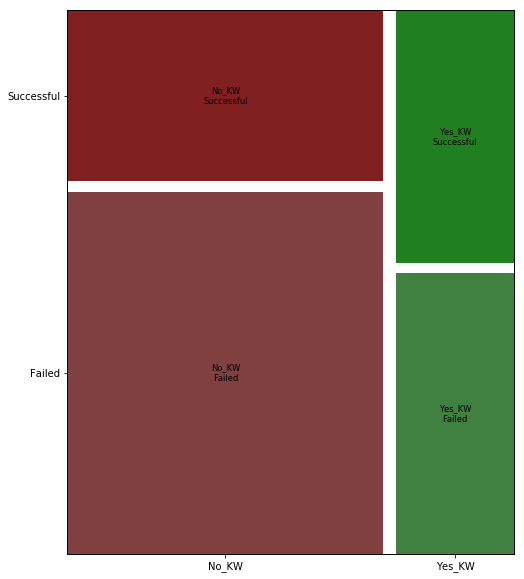

In [35]:
# create a mosaic graph 
mosaic(crosstabkw.stack(),gap=0.03 );

## Testing No-Correlation

An assertion that two variables are not related is based on a concept in statistics called the null hypothesis.

The null hypothesis in this case would state, **“There is no relationship between Keyword in a project name and Success of a project.”**

In a test for independence between Successful and Contain Keyword , if there is no relationship, then the null hypothesis is true. The alternative hypothesis is that the variables are in fact related – they are dependent, rather than independent.

The association between binary numbers can be interpreted the same way as the Pearson Correlation r. In fact, phi is a shortcut method for computing r.

In [31]:
import scipy.stats as stats

In [32]:
#https://cooldata.wordpress.com/2015/09/03/testing-associations-between-two-categorical-variables/

In [33]:
x = df.contain_kw
y = df.successful

In [34]:
stats.pearsonr(x, y)

(0.14132597131533309, 0.0)

In [39]:
np.corrcoef([x, y])

array([[ 1.        ,  0.14132597],
       [ 0.14132597,  1.        ]])

In [40]:
stats.chisquare(f_obs= x,   # Array of observed counts
                f_exp= y, ddof=1, axis=None)

C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Power_divergenceResult(statistic=nan, pvalue=nan)

In [38]:
stats.power_divergence(x, y, ddof=1)

C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Jimena\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Power_divergenceResult(statistic=nan, pvalue=nan)

In [41]:
stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 1)   # Df = number of variable categories - 1

3.8414588206941236

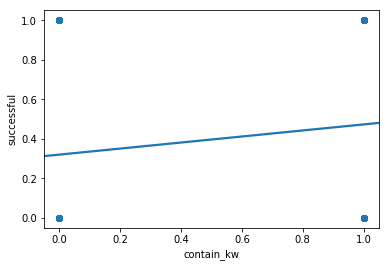

In [77]:
#sns.regplot(x=df['contain_kw'], y=df['successful'])

In [86]:
#kw_graph = most100diff['prop_successful'][:30]

In [48]:
x = dfname.name_low.str.contains('album')
dfkey[x == True]

,name,category,main_category,country,successful,name_len,name_low,name_words,number_words,contain_kw
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0,49,toshicapital rekordz needs help to complete album,"[toshicapital, rekordz, needs, help, to, complete, album]",7,0.0
18,Mike Coreys Darkness Light Album,Music,Music,US,1,32,mike coreys darkness light album,"[mike, coreys, darkness, light, album]",5,0.0
25,Matt Cavenaugh Jenny Powers make their 1st album!,Music,Music,US,1,50,matt cavenaugh jenny powers make their 1st album,"[matt, cavenaugh, jenny, powers, make, their, 1st, album]",8,0.0
36,Arrows Sound Debut Album,Indie Rock,Music,US,1,24,arrows sound debut album,"[arrows, sound, debut, album]",4,0.0
93,Glyscian Debut Album Recording,Rock,Music,US,0,31,glyscian debut album recording,"[glyscian, debut, album, recording]",4,0.0
110,Be part of the next SMB Project album,Indie Rock,Music,US,1,37,be part of the next smb project album,"[be, part, of, the, next, smb, project, album]",8,0.0
114,Ebony ChildMusic Artist drops New Album Comic Book Film,Pop,Music,US,0,55,ebony childmusic artist drops new album comic book film,"[ebony, childmusic, artist, drops, new, album, comic, book, film]",9,0.0
148,Rising Star Unsigned Artist Compilation Album,Hip-Hop,Music,GB,0,45,rising star unsigned artist compilation album,"[rising, star, unsigned, artist, compilation, album]",6,0.0
176,Canadian Invasions Choose Your Own Adventure Album,Pop,Music,US,1,50,canadian invasions choose your own adventure album,"[canadian, invasions, choose, your, own, adventure, album]",7,0.0
182,Keys to the Moons First Full Length Album!,Music,Music,US,1,42,keys to the moons first full length album,"[keys, to, the, moons, first, full, length, album]",8,0.0


In [40]:
sorted_bydiff.shape

(169592, 5)

In [32]:
dfname.shape

(378650, 21)

In [33]:
dfname[['successful', 'number_words']].groupby('successful').number_words.mean()

successful
0    5.170793
1    5.735957
Name: number_words, dtype: float64

In [34]:
dfname[['successful', 'name_len']].groupby('successful').mean()

,name_len
successful,
0,31.836251
1,34.781074
